### ECGbe-GAN: A novel deep learning approach for eliminating ECG interference from EMG data
Lucas Haberkamp<sup>1,2,3</sup> Charles A. Weisenbach<sup>1,2</sup> Peter Le<sup>4</sup>  
<sup>1</sup>Naval Medical Research Unit Dayton, Wright-Patterson Air Force Base, OH, USA   
<sup>2</sup>Oak Ridge Institute for Science and Education, Oak Ridge, TN, USA   
<sup>3</sup>Leidos, Reston, VA, USA   
<sup>4</sup>Air Force Research Laboratory, 711th Human Performance Wing, Wright-Patterson Air Force Base, OH, USA 

#### This notebook is used to train the Supervised deep learning model

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn import utils
from tensorflow.keras.activations import gelu
from sklearn.preprocessing import StandardScaler
import pandas as pd
from scipy import signal
import time

Load in synthetic training & validation data

In [12]:
x_train = np.load('../../Data/Training Data/Supervised/x_train.npy')
y_train = np.load('../../Data/Training Data/Supervised/y_train.npy')

x_val = np.load('../../Data/Training Data/Validation/x_val.npy')
y_val = np.load('../../Data/Training Data/Validation/y_val.npy')

print("x_train_shape:", x_train.shape)
print("y_train_shape:", y_train.shape)
print("x_val_shape:", x_val.shape)
print("y_val_shape:", y_val.shape)

x_train_shape: (5000, 800, 1)
y_train_shape: (5000, 800, 1)
x_val_shape: (1000, 800, 1)
y_val_shape: (1000, 800, 1)


Visually confirm the synthetic data is paired

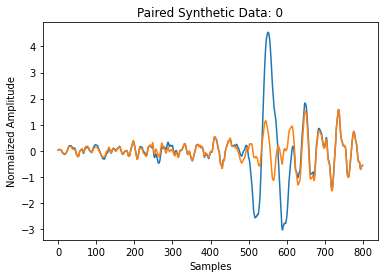

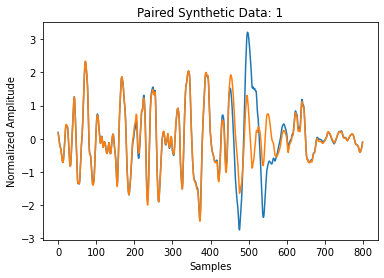

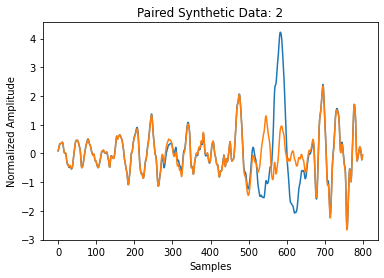

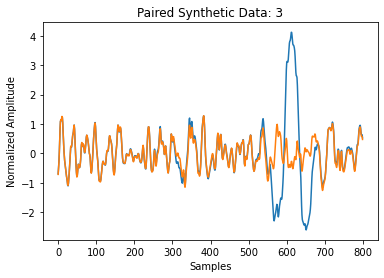

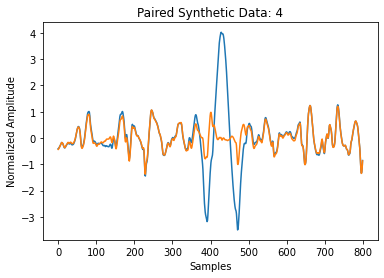

In [13]:
for i in range(5):
  plt.plot(x_train[i])
  plt.plot(y_train[i])
  plt.title("Paired Synthetic Data: " + str(i))
  plt.ylabel('Normalized Amplitude')
  plt.xlabel('Samples')
  plt.show()

Define the TCN separation module

In [14]:
def tcn_block(inputs, filters, dilation_rates):
  skips = []

  res = inputs
  for dilation in dilation_rates:
    x = LayerNormalization()(res)
    x = Conv1D(filters*3, kernel_size=1, padding='same', activation=gelu)(x)

    x = LayerNormalization()(x)
    x = SeparableConv1D(filters*3, dilation_rate=dilation,
                        kernel_size=3, padding='same', activation=gelu)(x)
    x = SpatialDropout1D(0.125)(x)

    x = LayerNormalization()(x)
    x = Conv1D(filters, kernel_size=1, padding='same')(x)

    skips.append(x)
    res = Add()([x, res])

  x = Activation(gelu)(Add()(skips))
  x = LayerNormalization()(x)
  return x

Define the neural network model

In [15]:
def build_model():
  dilation_rates = [1,2,4,8,16,32,64,128] * 2

  inputs = Input(shape=(None, 1))

  x = Conv1D(filters=32, kernel_size=7, padding='same', activation=gelu)(inputs)
  x = LayerNormalization()(x)

  x = Conv1D(filters=64, strides=2, kernel_size=3, padding='same', activation=gelu)(x)
  x = SpatialDropout1D(0.125)(x)
  x = LayerNormalization()(x)

  x = Conv1D(filters=64, kernel_size=1, padding='same', activation=gelu)(x)

  sep = tcn_block(x, filters=64, dilation_rates=dilation_rates)
  sep = Conv1D(filters=64, kernel_size=1, padding='same', activation='sigmoid')(sep)

  mask = Multiply()([x, sep])
  mask = LayerNormalization()(mask)

  x = Conv1DTranspose(filters=32, strides=2, kernel_size=3, padding='same', activation=gelu)(mask)
  x = SpatialDropout1D(0.125)(x)
  x = LayerNormalization()(x)

  outputs = Conv1D(1, kernel_size=7, padding='same')(x)

  return Model(inputs, outputs)

In [16]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

Set model parameters, initialize, and compile the model

In [18]:
# set model parameters
batch_size = 64
epochs = 191
optimizer = Adam(learning_rate=1e-4)
loss = 'mse'

# construct the model
model = build_model()

# compile the model
model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 conv1d_37 (Conv1D)             (None, None, 32)     256         ['input_2[0][0]']                
                                                                                                  
 layer_normalization_53 (LayerN  (None, None, 32)    64          ['conv1d_37[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv1d_38 (Conv1D)             (None, None, 64)     6208        ['layer_normalization_53[0]

In [ ]:
# train the model
history = model.fit(x_train,y_train,
            validation_data=(x_val, y_val),
            epochs=epochs,
            shuffle=True,
            batch_size=batch_size,
            verbose=1)


Training performance

In [ ]:
val_loss = np.expand_dims(history.history['val_loss'], axis=1)
loss = np.expand_dims(history.history['loss'], axis=1)

training_info = np.concatenate([val_loss, loss], axis=1)
np.save('../../Models/Supervised/Performance.npy', training_info)

# Obtain number of epochs
epochs = range(len(loss))
# Plot loss and val loss
plt.plot(val_loss, label='validation_loss')
plt.plot(loss, label='training_loss')
plt.legend()
plt.title('Training Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Save model

In [ ]:
MODEL_PATH = '../../Models/Supervised/Supervised_Model.h5'
model.save(MODEL_PATH)